 # ATSC 409 Mini-Project 2

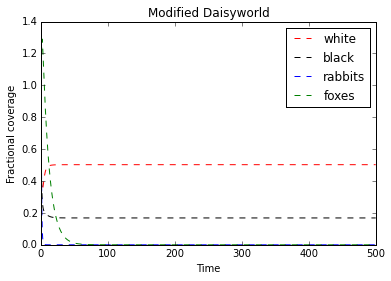

In [2]:
%matplotlib inline
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


class IntegMP(Integrator):

    def set_yinit(self):
        # Read in 'albedo_white chi S0 L albedo_black Rs albedo_ground'.
        # Read in new params 'lamb pi bigSigma mu gamma eta'.
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        # Read in 'whiteconc blackconc'.
        # Read in new params 'rabbitconc foxconc'.
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc,
             self.initvars.rabbitconc, self.initvars.foxconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            input:  yvals -- array of dimension [2] with the white [0] and 
                    black [1] daisy fraction
            output: white temperature (K), black temperature (K), equilibrium 
                    temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.Rs * user.L* user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0] = fraction white daisies
           y[1] = fraction black daisies
           y[2] = fraction rabbit pop
           y[3] = fraction fox pop
           no feedback between daisies and albedo_p (set to ground albedo)
        """
        temp_w, temp_b, temp_e = self.find_temp(y)

        if(temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if(temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
            
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w*bare - (user.chi + y[2]*user.lamb))
        f[1] = y[1] * (beta_b*bare - (user.chi + y[2]*user.lamb))
        f[2] = y[2] * (user.pi*(1-bare) - (user.bigSigma + y[3]*user.mu))
        f[3] = y[3] * (y[2]*user.gamma - user.eta)
        return f


theSolver = IntegMP('mp2.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
pops = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, pops['white'])
line2, = theAx.plot(timevals, pops['black'])
line3, = theAx.plot(timevals, pops['rabbits'])
line4, = theAx.plot(timevals, pops['foxes'])
line1.set(linestyle='--', color='r', label='white')
line2.set(linestyle='--', color='k', label='black')
line3.set(linestyle='--', color='b', label='rabbits')
line4.set(linestyle='--', color='g', label='foxes')
theAx.set_title('Modified Daisyworld')
theAx.set_xlabel('Time')
theAx.set_ylabel('Fractional coverage')
out=theAx.legend(loc='best')